In [0]:
import torch
import numpy as np
from torchvision import datasets
from torchvision.transforms import transforms
from torch.utils.data.sampler import SubsetRandomSampler

In [12]:
num_workers = 0
batch_size=32
valid_size=0.2
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
train_data = datasets.CIFAR10('data',train=True,download=True,transform=transform)
test_data = datasets.CIFAR10('data',train=False,download=True,transform=transform)

num_train=len(train_data)
indices=list(range(num_train))
np.random.shuffle(indices)

split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers)

classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

Files already downloaded and verified
Files already downloaded and verified


In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

def imshow(image):
  image= image/2 +0.5
  plt.imshow(np.transpose(image, (1, 2, 0)))

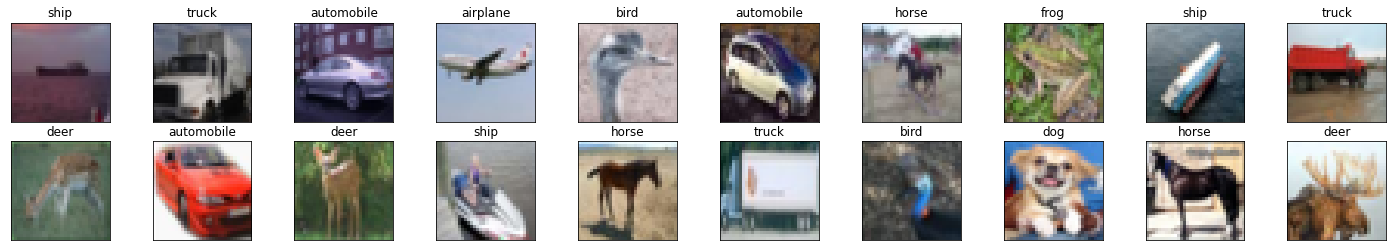

In [14]:
dataiter = iter(train_loader)
images,labels=dataiter.next()
images=images.numpy()

fig=plt.figure(figsize=(25,4))

for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

In [0]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
  def __init__(self):
    super(Net,self).__init__()
    self.conv1=nn.Conv2d(3,16,3,padding=1)
    self.conv2=nn.Conv2d(16,32,3,padding=1)
    self.conv3=nn.Conv2d(32,64,3,padding=1)
    self.conv4=nn.Conv2d(64,128,3,padding=1)
    
    self.pool = nn.MaxPool2d(2,2)

    self.fc1=nn.Linear(128*2*2,500)
    self.fc2=nn.Linear(500,10)

    self.dropout=nn.Dropout(0.25)


  def forward(self,x):


    x=self.pool(F.relu(self.conv1(x)))
    x=self.pool(F.relu(self.conv2(x)))
    x=self.pool(F.relu(self.conv3(x)))
    x=self.pool(F.relu(self.conv4(x)))

    x=x.view(-1, 128 * 2 * 2)

    x=self.dropout(F.relu(self.fc1(x)))
    x=self.fc2(x)

    return x



In [20]:
model = Net()
print(model)
train_on_gpu=torch.cuda.is_available()
if train_on_gpu:
    model.cuda()

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=512, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)


In [0]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(),lr=0.01)



In [35]:
# training 
epochs=17
validation_loss_min=np.Inf
for e in range(epochs):
  validation_loss=0.0
  training_loss=0.0
  model.train()
  for images,labels in train_loader:
    if train_on_gpu:
      images,labels = images.cuda(),labels.cuda()
    optimizer.zero_grad()
    output=model(images)
    loss=criterion(output,labels)
    loss.backward()
    optimizer.step()
    training_loss+=loss.item()*images.size(0)
  
  model.eval()
  for(images,labels) in valid_loader:
    if train_on_gpu:
      images,labels = images.cuda(),labels.cuda()
    output=model(images)
    loss=criterion(output,labels)
    validation_loss+=loss.item()*images.size(0)

  training_loss=training_loss/len(train_loader.sampler)
  validation_loss=validation_loss/len(test_loader.sampler)

  print('epoc : {}  Training Loss : {:.6f}  Validation Loss : {:.6f} '.format(e+1,training_loss,validation_loss))

  if validation_loss <= validation_loss_min:
    print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(validation_loss_min,validation_loss))
    torch.save(model.state_dict(),'model_cifar.pt')
    validation_loss_min=validation_loss


epoc : 1  Training Loss : 1.674768  Validation Loss : 1.657755 
Validation loss decreased (inf --> 1.657755).  Saving model ...
epoc : 2  Training Loss : 1.681860  Validation Loss : 1.639638 
Validation loss decreased (1.657755 --> 1.639638).  Saving model ...
epoc : 3  Training Loss : 1.708624  Validation Loss : 1.611366 
Validation loss decreased (1.639638 --> 1.611366).  Saving model ...
epoc : 4  Training Loss : 1.679252  Validation Loss : 1.687734 
epoc : 5  Training Loss : 1.674372  Validation Loss : 1.631968 
epoc : 6  Training Loss : 1.646609  Validation Loss : 1.591482 
Validation loss decreased (1.611366 --> 1.591482).  Saving model ...
epoc : 7  Training Loss : 1.666622  Validation Loss : 1.616743 
epoc : 8  Training Loss : 1.648713  Validation Loss : 1.592361 
epoc : 9  Training Loss : 1.643439  Validation Loss : 1.578669 
Validation loss decreased (1.591482 --> 1.578669).  Saving model ...
epoc : 10  Training Loss : 1.622028  Validation Loss : 1.577102 
Validation loss dec

In [36]:
model.load_state_dict(torch.load('model_cifar.pt'))

<All keys matched successfully>

In [41]:
# test

# prediction input to be fixed

test_loss=0.0
class_correct=list(0. for i in  range(10))
class_total=class_correct
model.eval()
for image, label in test_loader:
  if train_on_gpu:
    image,label=image.cuda(),label.cuda()
  output = model(image)
  loss=criterion(output,label)
  test_loss+=loss.item()*image.size(0)
  _,pred=torch.max(output,1)
  print(pred.size())
  correct_tensor=pred.eq(image.data.view_as(pred))
  correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
  for i in range(batch_size):
    l = image.data[i]
    class_correct[l] += correct[i].item()
    class_total[l] += 1
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))


torch.Size([32])


RuntimeError: ignored

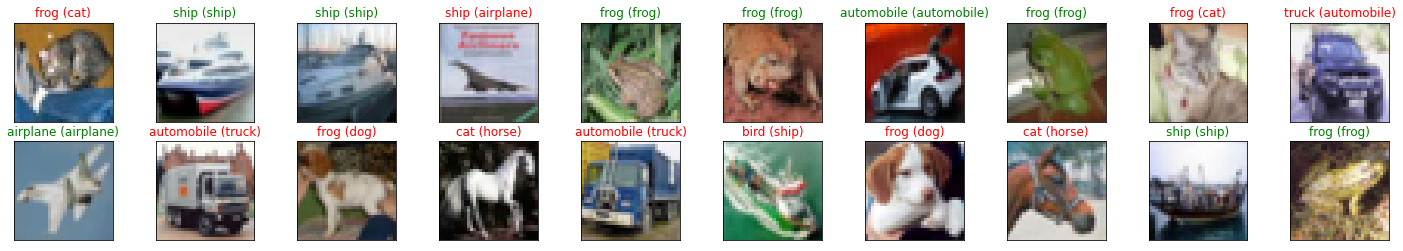

In [42]:
dataiter = iter(test_loader)
images, labels = dataiter.next()
images.numpy()

if train_on_gpu:
    images = images.cuda()

output = model(images)
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images.cpu()[idx])
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))